# Exploration 12
# Session based Recommendation

## 프로젝트 - Movielens 영화 SBR
### |프로젝트 학습 과정

1. 데이터의 전처리
    - 사용할 데이터: [MovieLens 1M Dataset](https://grouplens.org/datasets/movielens/1m/)
2. 미니 배치의 구성
    - 데이터셋과 미니 배치를 구성
3. 모델 구성
4. 모델 학습
5. 모델 테스트
    - 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### |프로젝트 평가
| |평가문항|상세기준|
|------|---|---|
|1|Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2| RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3| 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.| 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

# Data Info
MovieLens에 가입한 사람들의 영화 평점 평가 정보가 포함되어 있습니다. 2000년에 MovieLens에 가입한 6,040명의 MovieLens 사용자가 만든 약 3,900개의 영화에 대한 약 1백만 개의 익명 등급이 포함되어 있습니다.

## Summary
movies: 3,900   
rating: 1,000,209   
user: 6,040   

In [453]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [454]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None,
                       usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Timestamp'], inplace=True) 
orginal_data_size = len(data)

data

,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [455]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserId     1000209 non-null  int32
 1   ItemId     1000209 non-null  int32
 2   Rating     1000209 non-null  int32
 3   Timestamp  1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


- 'ratings.dat' 파일은 SessionID 대신 UserID 항목이 들어갔습니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

이 정보를 바탕으로 오늘의 실습 과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

# 1. 데이터 전처리

## Session 구분

In [456]:
print("UserID의 고유한 값: ", data['UserId'].nunique())
print("ItemID의 고유한 값: ", data['ItemId'].nunique())

UserID의 고유한 값:  6040
ItemID의 고유한 값:  3706


'rating.dat' Dataset에는 SessionID 대신 UserID 값이 들어갔고, 이를 이용해야 하기 때문에 session의 이름으로 'UserID' 컬럼을 이용해 보겠습니다!

In [457]:
# 각 유저별 사람들이 리뷰를 남긴 개수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [458]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

가장 많이 남긴 사람은 2314개나 남겼습니다. 가장 적은 사람은 1개입니다. 사실 이 데이터는 리뷰를 20개 이상 남긴 사람만 모아둔 데이터이기 때문에 최솟값은 20이 맞습니다. 평균이 192, 중앙값이 96인 것으로 보아 헤비 유저가 많은 것 같군요!

영화 리뷰를 1968개나 남긴 헤비 유저를 확인해보겠습니다. 시간이 Timestamp로 되어있는데, 이는 'timestamp = 초 * 분 * 시 * 일' 입니다. 
```
timestamp = 60 * 60 * 24 *30
print(timestamp)
>>> 2592000
```

이를 date 형식으로 바꿔주는 방법을 찾아보겠습니다.

## TImestamp → Datetime 형식 변환

In [459]:
len(data['Timestamp'])

1000209

In [460]:
data

,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [461]:
from datetime import datetime
import time

date = []

for i in range(1000209):
    time = datetime.fromtimestamp(data['Timestamp'][i]).strftime('%Y-%m-%d %H:%M:%S')
    time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S') # datetime 으로 변환
    date.append(time)

In [462]:
data['Time'] = date

In [463]:
data

,UserId,ItemId,Rating,Timestamp,Time
31,1,3186,4,978300019,2000-12-31 22:12:40
22,1,1270,5,978300055,2000-12-31 22:35:09
27,1,1721,4,978300055,2000-12-31 22:32:48
37,1,1022,5,978300055,2000-12-31 22:04:35
24,1,2340,3,978300103,2001-01-06 23:38:11
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2000-04-26 02:35:41
999988,6040,1921,4,997454464,2000-04-25 23:21:27
1000172,6040,1784,3,997454464,2000-04-25 23:19:06
1000167,6040,161,3,997454486,2000-04-26 02:20:48


In [464]:
data.drop('Timestamp', axis=1, inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:12:40
22,1,1270,5,2000-12-31 22:35:09
27,1,1721,4,2000-12-31 22:32:48
37,1,1022,5,2000-12-31 22:04:35
24,1,2340,3,2001-01-06 23:38:11
...,...,...,...,...
1000019,6040,2917,4,2000-04-26 02:35:41
999988,6040,1921,4,2000-04-25 23:21:27
1000172,6040,1784,3,2000-04-25 23:19:06
1000167,6040,161,3,2000-04-26 02:20:48


## 평점 3점 이하는 삭제
추천 시스템을 만들 예정이니 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외합니다.

In [465]:
orginal_data_size = len(data)
print("원래 데이터 수: ", orginal_data_size)

원래 데이터 수:  1000209


In [466]:
data = data[data['Rating'] >=  3]
filtered_data_size = len(data)

In [467]:
print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


3점 미만의 점수를 삭제하였고 original data의 83.63만 남게 되었습니다.

In [468]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:12:40
22,1,1270,5,2000-12-31 22:35:09
27,1,1721,4,2000-12-31 22:32:48
37,1,1022,5,2000-12-31 22:04:35
24,1,2340,3,2001-01-06 23:38:11
...,...,...,...,...
1000019,6040,2917,4,2000-04-26 02:35:41
999988,6040,1921,4,2000-04-25 23:21:27
1000172,6040,1784,3,2000-04-25 23:19:06
1000167,6040,161,3,2000-04-26 02:20:48


## 헤비 유저 확인해보기
아까 앞에서 3점 미만의 리뷰는 삭제했기 때문에 session_length를 다시 확인해 보겠습니다.

In [469]:
session_length = data.groupby('UserId').size()
session_length.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
dtype: float64

유저는 6040에서 1명이 줄어들었고, 평균 196 → 138, 중앙값 96 → 81 로 줄어들었습니다. 편차가 살짝 줄어 들었음을 알 수 있습니다. 또한, 가장 많이 남긴 수가 1968개로 변경되었습니다. 이 데이터를 더 상세히 살펴보겠습니다.

In [470]:
long_session = session_length[session_length==1968].index[0]
heavy_user = data[data['UserId']==long_session]
heavy_user

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:14:32
697168,4169,2617,4,2000-11-04 03:57:45
697185,4169,2628,4,2000-12-03 01:00:32
697219,4169,2653,4,2000-12-12 02:59:09
697275,4169,423,3,2001-04-26 22:29:05
...,...,...,...,...
697055,4169,3207,3,2000-08-03 20:12:38
695958,4169,3413,3,2000-10-15 03:43:34
695702,4169,1413,3,2001-01-26 02:42:04
697358,4169,494,4,2000-10-15 03:16:55


In [471]:
print("리뷰를 남긴 첫째 날: ", heavy_user['Time'].min())
print("리뷰를 남긴 마지막 날", heavy_user['Time'].max())

리뷰를 남긴 첫째 날:  2000-08-03 20:09:52
리뷰를 남긴 마지막 날 2002-06-15 21:25:37


- 확인해보니 2000년8월3일부터 2002년6월15일까지의 날짜로 확인이 되네요. 약 2년 정도의 시간 동안 리뷰를 약 2000개나 남겼네요!

## session_length의 정의

In [472]:
session_length.quantile(0.999)

1118.8860000000013

In [473]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

(cumsum은 분포 누적합을 도와주는 함수입니다.)

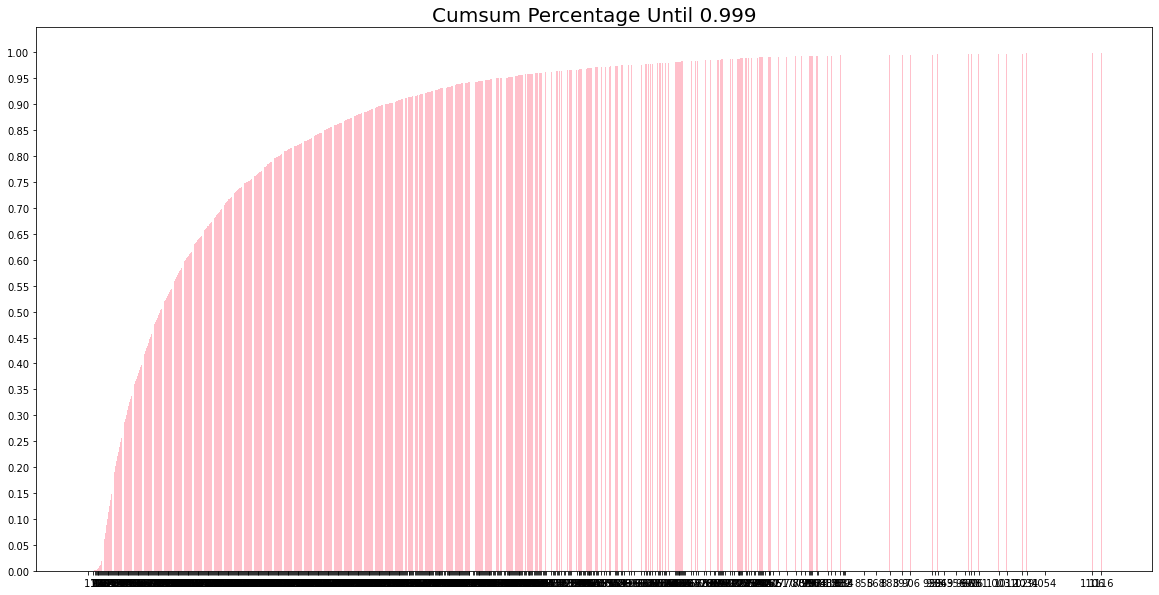

In [474]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='pink')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

위의 값과 그래프를 통해 확인할 수 있는 점은 User의 99.9%는 남긴 리뷰가 1,118개 이하라는 점입니다. 하지만 조금 이상함을 느낄 수 있습니다.

In [475]:
length_percent_cumsum_001 = length_percent_cumsum[length_percent_cumsum > 0.999]
length_percent_cumsum_001

1119    0.999006
1136    0.999172
1145    0.999338
1146    0.999503
1515    0.999669
1715    0.999834
1968    1.000000
dtype: float64

In [476]:
len(length_percent_cumsum_001)

7

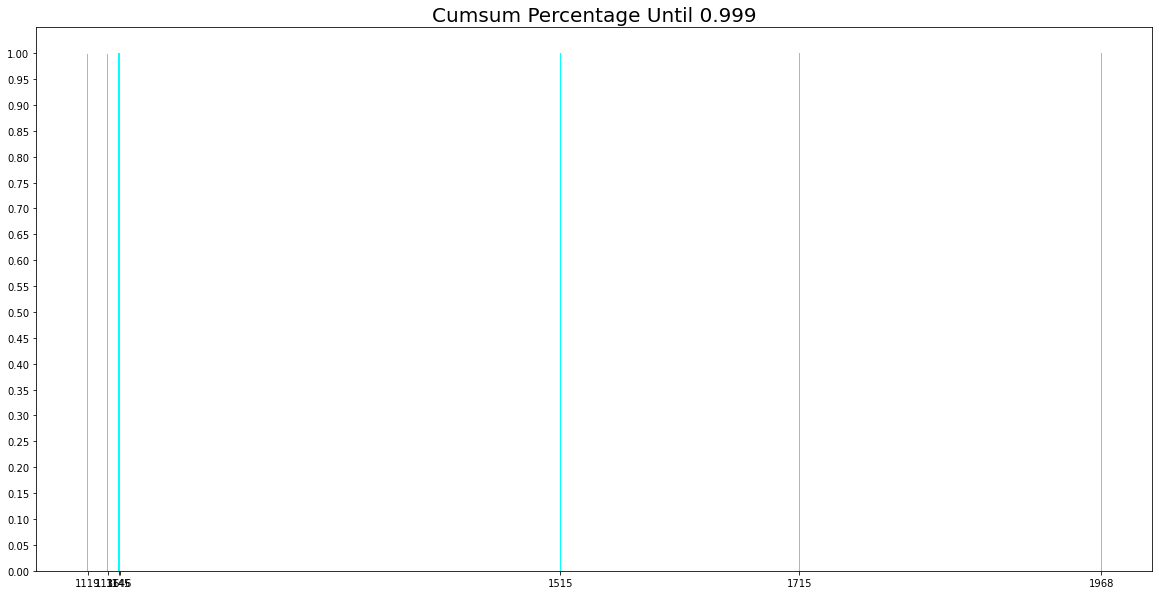

In [477]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.bar(x=length_percent_cumsum_001.index,
       height=length_percent_cumsum_001, color='aqua')
plt.xticks(length_percent_cumsum_001.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

상위 0.001%를 조회해보니 7개의 데이터가 나옵니다. 다시 session_length를 살펴보겠습니다.

In [478]:
# 유저별 리뷰 수 
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [479]:
# session_length의 고유값
session_length.nunique()

643

In [480]:
length_count

1       1
7       1
9       4
10      1
11      5
       ..
1145    1
1146    1
1515    1
1715    1
1968    1
Length: 643, dtype: int64

- 유저별 리뷰 수로 다시 groupby를 한 거니 643개의 집계로 묶이게 되었고, 이를 session 이라고 보기엔 애매해졌습니다. 원래 session_length는 한 세션 동안 몇 번의 액션을 취했는지의 의미가 되어야 하기 때문이죠. 지금 만들어진 session_length는 실제 sessionID가 아닌 UserID를 기준으로 몇 번의 액션(리뷰 남기기)이 취해졌는지를 액션끼리 한 번더 집계하여 대략적으로 보여주고 있습니다.

- 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용합니다. 이 데이터는 유저와 이용한 상품 정보 관계에 대해 Matrix Factorization을 사용할 수 있습니다. 이를 이용하여 다시 groupby 하도록 하겠습니다.

In [481]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:12:40
22,1,1270,5,2000-12-31 22:35:09
27,1,1721,4,2000-12-31 22:32:48
37,1,1022,5,2000-12-31 22:04:35
24,1,2340,3,2001-01-06 23:38:11
...,...,...,...,...
1000019,6040,2917,4,2000-04-26 02:35:41
999988,6040,1921,4,2000-04-25 23:21:27
1000172,6040,1784,3,2000-04-25 23:19:06
1000167,6040,161,3,2000-04-26 02:20:48


## Session_length 재정의

In [482]:
new_session = data.groupby(['UserId', 'Time'])['ItemId'].size().reset_index()
new_session.reset_index(inplace = True)
new_session

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:01:43,1
3,3,1,2000-12-31 22:02:52,1
4,4,1,2000-12-31 22:04:35,1
...,...,...,...,...
430793,430793,6040,2001-08-10 14:39:27,1
430794,430794,6040,2001-08-10 14:39:58,1
430795,430795,6040,2001-08-10 14:41:04,2
430796,430796,6040,2001-08-10 14:41:26,1


이는 유저별, 시간별로 'ItemId'의 수를 집계한 결과입니다. 이는 유저들의 시간 정보에 따라 리뷰를 얼마나 남겼는지를 알 수 있기 때문에 기존의 Session_length 보다 실제 세션과 비슷하다고 볼 수 있을 것 같습니다!

In [483]:
data = pd.merge(data, new_session, on = ['UserId', 'Time'])
data

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,2000-12-31 22:12:40,6,3
1,1,2018,4,2000-12-31 22:12:40,6,3
2,1,745,3,2000-12-31 22:12:40,6,3
3,1,1270,5,2000-12-31 22:35:09,20,1
4,1,1721,4,2000-12-31 22:32:48,17,1
...,...,...,...,...,...,...
836473,6040,3182,5,2000-04-25 23:10:19,430649,1
836474,6040,1270,3,2000-04-25 23:06:17,430645,1
836475,6040,1947,4,2000-07-28 23:59:59,430778,1
836476,6040,2571,4,2000-04-25 23:19:06,430660,2


In [484]:
data.drop('ItemId_x', axis=1, inplace=True)
data.rename(columns={'index':'SessionId'}, inplace=True)
data.rename(columns={'ItemId_y':'ItemId'}, inplace=True)
data

,UserId,Rating,Time,SessionId,ItemId
0,1,4,2000-12-31 22:12:40,6,3
1,1,4,2000-12-31 22:12:40,6,3
2,1,3,2000-12-31 22:12:40,6,3
3,1,5,2000-12-31 22:35:09,20,1
4,1,4,2000-12-31 22:32:48,17,1
...,...,...,...,...,...
836473,6040,5,2000-04-25 23:10:19,430649,1
836474,6040,3,2000-04-25 23:06:17,430645,1
836475,6040,4,2000-07-28 23:59:59,430778,1
836476,6040,4,2000-04-25 23:19:06,430660,2


## Session Time

In [485]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 데이터가 발생한 시간에 대해 조회해 보았는데, 2000년 4월부터 2003년 2월까지 약 3년의 데이터가 있습니다. 영화 시장도 3년이면 꽤 긴 시간인 것 같습니다. 최근 얼마 동안의 기록을 불러오느냐가 중요한 기준이 될 것 같습니다.

In [486]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 836477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UserId     836478 non-null  int32         
 1   Rating     836478 non-null  int32         
 2   Time       836478 non-null  datetime64[ns]
 3   SessionId  836478 non-null  int64         
 4   ItemId     836478 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 31.9 MB


Time은 datetime 함수로 잘 변경되어 있습니다. datetime 함수는 timedelta 함수를 이용하여 날짜를 편하게 계산 할 수 있다는 장점이 있습니다.

In [487]:
two_years_ago = latest - dt.timedelta(730) # 2년 전 이전 날짜
data[data['Time'] > two_years_ago] # 확인

,UserId,Rating,Time,SessionId,ItemId
2091,19,4,2001-07-08 01:43:18,1198,1
2182,19,3,2001-07-08 01:43:56,1199,1
2193,20,5,2001-12-29 23:37:51,1207,4
2194,20,4,2001-12-29 23:37:51,1207,4
2195,20,3,2001-12-29 23:37:51,1207,4
...,...,...,...,...,...
836434,6040,4,2001-08-10 14:39:27,430793,1
836440,6040,4,2001-08-10 14:35:40,430788,1
836462,6040,3,2001-08-10 14:29:56,430781,1
836466,6040,4,2001-08-10 14:41:26,430796,1


In [488]:
one_year_ago = latest - dt.timedelta(365) # 1년 전 이전 날짜
data[data['Time'] > one_year_ago] # 확인

,UserId,Rating,Time,SessionId,ItemId
4260,36,4,2002-03-12 03:58:05,2544,1
4274,36,5,2002-03-12 03:52:07,2541,1
4325,36,4,2002-03-12 03:54:09,2543,1
4328,36,4,2002-12-22 08:18:29,2557,3
4329,36,3,2002-12-22 08:18:29,2557,3
...,...,...,...,...,...
830253,5996,4,2002-04-29 20:30:30,428069,1
830254,5996,4,2002-04-29 16:21:02,428016,1
830256,5996,3,2002-04-29 16:19:18,428013,1
830263,5996,3,2002-04-29 16:23:19,428019,1


In [489]:
three_years_ago = latest - dt.timedelta(1095) # 1년 전 이전 날짜
data[data['Time'] > three_years_ago] # 확인

,UserId,Rating,Time,SessionId,ItemId
0,1,4,2000-12-31 22:12:40,6,3
1,1,4,2000-12-31 22:12:40,6,3
2,1,3,2000-12-31 22:12:40,6,3
3,1,5,2000-12-31 22:35:09,20,1
4,1,4,2000-12-31 22:32:48,17,1
...,...,...,...,...,...
836473,6040,5,2000-04-25 23:10:19,430649,1
836474,6040,3,2000-04-25 23:06:17,430645,1
836475,6040,4,2000-07-28 23:59:59,430778,1
836476,6040,4,2000-04-25 23:19:06,430660,2


가장 최근의 날짜에서 1, 2년 전을 비교해보니까 58,022개, 18,107개로 데이터의 row 수가 차이가 나는군요. 원래 836478 rows 이었던 것을 비교하면 가장 처음 리뷰를 남겼던 oldest 기준으로 1년이 가장 데이터가 많다는 것을 알 수 있네요.

## Data Clenasing

short_session을 제거하고 unpopular item을 제거하겠습니다. 그런데 이 둘을 제거하면 다시 길이가 1인 session이 생길 수 있습니다. 이를 위해 반복문을 통해 지속적으로 제거해줍니다.

In [490]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [491]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,Rating,Time,SessionId,ItemId
0,1,4,2000-12-31 22:12:40,6,3
1,1,4,2000-12-31 22:12:40,6,3
2,1,3,2000-12-31 22:12:40,6,3
6,1,3,2001-01-06 23:38:11,31,3
7,1,3,2001-01-06 23:38:11,31,3
...,...,...,...,...,...
836463,6040,3,2000-04-26 02:33:58,430706,3
836464,6040,3,2000-04-26 02:33:58,430706,3
836465,6040,4,2000-04-26 02:33:58,430706,3
836476,6040,4,2000-04-25 23:19:06,430660,2


## Train/Valid/Test split

추천 시스템은 '현재'를 예측하는 것이 가장 중요합니다. 유저들의 활동 패턴이 달라지기 때문에, 최근 2년 전의 성능이 좋은 모델을 쓰는 건 예측이 잘 맞지 않을 수 있습니다. 위에서 날짜별로 데이터 수를 확인해본 결과 데이터 크기가 애매해서 저는 전체 데이터를 사용하되, 비율로 test, validation을 나누기로 했습니다.

In [492]:
tr = data[:500000]
val = data[500000:560000]
test = data[560000:]

In [505]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [506]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 500000
	 Sessions: 168307
	 Items: 26
	 First Time : 2000-07-05 02:25:12
	 Last Time : 2003-02-25 19:06:15

* valid Set Stats Info
	 Events: 60000
	 Sessions: 20784
	 Items: 17
	 First Time : 2000-05-30 01:45:49
	 Last Time : 2003-02-22 06:40:53

* test Set Stats Info
	 Events: 52789
	 Sessions: 18019
	 Items: 14
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2003-02-27 18:04:50



In [495]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로
# train data를 기준으로 인덱싱 해줍니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [496]:
print(tr.shape)
print(val.shape)
print(test.shape)

(500000, 6)
(60000, 6)
(52789, 6)


In [497]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Session-Parallel Mini-Batches

이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 합니다.

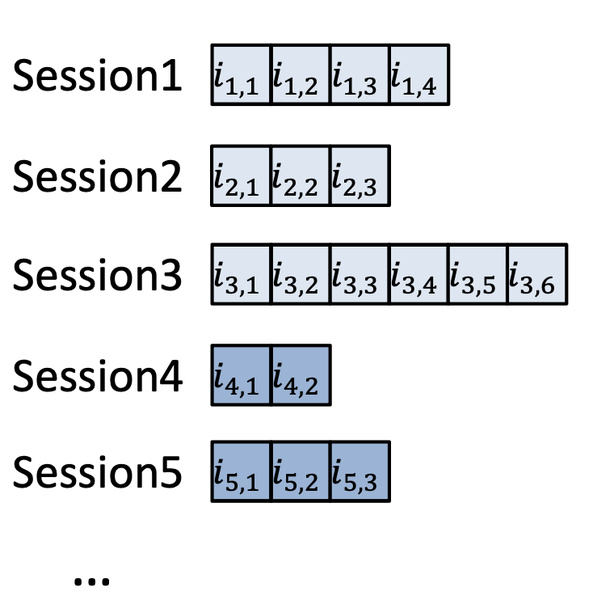

위 그림에서 Session 1, 2, 3을 하나의 mini-batch로 만든다면, 이 미니배치의 연산은 Session 3의 연산이 끝나야 끝나는 식입니다. 논문 저자는 대신 Session-Parallel Mini-Batches를 제안합니다. 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 뜻입니다.

아래 그림에서 session2가 끝나면 session4가 시작하는 방식입니다.

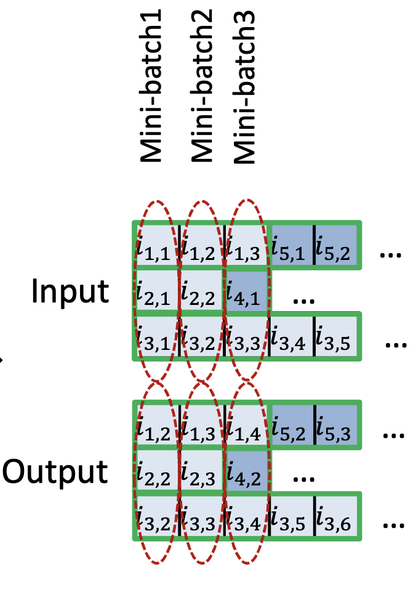

이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어집니다. 또한, Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 줍니다.

SAMPLING ON THE OUTPUT : Negative Sampling와 같은 개념입니다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling합니다.

Ranking Loss Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있습니다. 그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있습니다. 추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했습니다. 그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠습니다.

# 2. 미니 배치의 구성
## Session Dataset

In [516]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train data로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

clikc_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다. session_idx 변수는 각 세션을 인덱싱한 np.array입니다.

In [517]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,Rating,Time,SessionId,ItemId,item_idx
0,1,4,2000-12-31 22:12:40,6,3,0
1,1,4,2000-12-31 22:12:40,6,3,0
2,1,3,2000-12-31 22:12:40,6,3,0
6,1,3,2001-01-06 23:38:11,31,3,0
7,1,3,2001-01-06 23:38:11,31,3,0
8,1,3,2001-01-06 23:38:11,31,3,0
9,1,5,2000-12-31 22:37:48,26,2,1
10,1,4,2000-12-31 22:37:48,26,2,1
11,1,4,2000-12-31 22:33:59,18,2,1
12,1,5,2000-12-31 22:33:59,18,2,1


In [518]:
# 세션 시작 인덱스
tr_dataset.click_offsets

array([     0,      3,      5, ..., 499997, 499999, 500000], dtype=int32)

In [519]:
# 세션 인덱스
tr_dataset.session_idx

array([     0,      1,      2, ..., 168304, 168305, 168306])

## SessionDataLoader

In [520]:
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size
        
    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                # input 과 target 만들기
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask
                
            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)
       
    def initialize(self):
        first_iters = np.arange(self.batch_size)
        # 첫 배치에 사용할 세션 index 가져오기
        last_session = self.batch_size - 1
        # 마지막으로 다루고 있는 세션 index를 저장하기
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        # data 상에서 session이 시작된 위치 가져오기
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        # session이 끝난 위치 바로 다음 위치 가져오기
        mask = np.array([])
        # sessio의 모든 아이템을 다 돌은 경우 mask에 추가하기
        finished = False
        # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished
    
    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위한 상테 업데이트
        
        start += min_len
        # __iter__에서 min_len만큼 for문을 돌았으므로 start를 min_len만큼 더해줌
        mask = np.arange(self.batch_size)[(end-start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은
        # session이 끝났다는 뜻. mask에 기록해줌
        
        for i, idx in enumerate(mask, start=1):
            # mask에 추가된 세션 개수만큼 새로운 세션 돌리기
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:
                
            # 만약 새로운 세션이 마지막 세션 index보다 크면 모든 학습 데이터를 다 돌았다는 의미
                finished = True
                break
            # 새로운 시작, 끝점 업데이트
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            # 종료된 세션 대신 새로운 세션의 시작점을 기록
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            
        # 마지막 세션 위치 기록
        last_session += len(mask)
        return start, end, mask, last_session, finished

In [521]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,Rating,Time,SessionId,ItemId,item_idx
0,1,4,2000-12-31 22:12:40,6,3,0
1,1,4,2000-12-31 22:12:40,6,3,0
2,1,3,2000-12-31 22:12:40,6,3,0
6,1,3,2001-01-06 23:38:11,31,3,0
7,1,3,2001-01-06 23:38:11,31,3,0
8,1,3,2001-01-06 23:38:11,31,3,0
9,1,5,2000-12-31 22:37:48,26,2,1
10,1,4,2000-12-31 22:37:48,26,2,1
11,1,4,2000-12-31 22:33:59,18,2,1
12,1,5,2000-12-31 22:33:59,18,2,1


In [522]:
iter_ex = iter(tr_data_loader)

In [523]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 0 0 1]
Label Item Idx are :       [0 0 1 1]
Previous Masked Input Idx are []


# 3. 모델 구성
## 3-1 Evaluation Metric

In [524]:
def mrr_k(pred, truth: int, k:int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k:int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 3.2 Model Architecture

In [525]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [526]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [527]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)

In [528]:
model = create_model(args)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(32, 1, 26)]             0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      11700     
_________________________________________________________________
dropout_12 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_12 (Dense)             (32, 26)                  1326      
Total params: 13,026
Trainable params: 13,026
Non-trainable params: 0
_________________________________________________________________


# 4. 모델 학습 및 5. 모델 테스트

In [529]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [530]:
train_model(model, args)

Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0, train_loss=3.33]

	 - Recall@20 epoch 1: 0.437500
	 - MRR@20    epoch 1: 0.108219



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0, train_loss=3.32]

	 - Recall@20 epoch 2: 0.562500
	 - MRR@20    epoch 2: 0.099853



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.0312, train_loss=3.29]

	 - Recall@20 epoch 3: 0.562500
	 - MRR@20    epoch 3: 0.111746



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0, train_loss=3.28]

	 - Recall@20 epoch 4: 0.718750
	 - MRR@20    epoch 4: 0.139160



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0, train_loss=3.26]

	 - Recall@20 epoch 5: 0.968750
	 - MRR@20    epoch 5: 0.159978



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.23]

	 - Recall@20 epoch 6: 0.968750
	 - MRR@20    epoch 6: 0.181878



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.0312, train_loss=3.21]

	 - Recall@20 epoch 7: 1.000000
	 - MRR@20    epoch 7: 0.203623



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.2]

	 - Recall@20 epoch 8: 1.000000
	 - MRR@20    epoch 8: 0.263650



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.17]

	 - Recall@20 epoch 9: 1.000000
	 - MRR@20    epoch 9: 0.272191



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.281, train_loss=3.16]

	 - Recall@20 epoch 10: 1.000000
	 - MRR@20    epoch 10: 0.368917



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.344, train_loss=3.12]

	 - Recall@20 epoch 11: 1.000000
	 - MRR@20    epoch 11: 0.417460



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.1]

	 - Recall@20 epoch 12: 1.000000
	 - MRR@20    epoch 12: 0.433751



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.406, train_loss=3.09]

	 - Recall@20 epoch 13: 1.000000
	 - MRR@20    epoch 13: 0.439183



Train:   0%|          | 0/10365 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.07]

	 - Recall@20 epoch 14: 1.000000
	 - MRR@20    epoch 14: 0.502431



Evaluation:   0%|          | 1/1225 [00:00<03:01,  6.73it/s]

	 - Recall@20 epoch 15: 1.000000
	 - MRR@20    epoch 15: 0.504601



In [534]:
args2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model2 = create_model(args2)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(64, 1, 26)]             0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      11700     
_________________________________________________________________
dropout_14 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_14 (Dense)             (64, 26)                  1326      
Total params: 13,026
Trainable params: 13,026
Non-trainable params: 0
_________________________________________________________________


In [535]:
train_model(model2, args2)

Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.0156, train_loss=3.26]

	 - Recall@20 epoch 1: 0.937500
	 - MRR@20    epoch 1: 0.087254



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0, train_loss=3.25]

	 - Recall@20 epoch 2: 0.937500
	 - MRR@20    epoch 2: 0.101976



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.0156, train_loss=3.22]

	 - Recall@20 epoch 3: 0.937500
	 - MRR@20    epoch 3: 0.116740



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.0781, train_loss=3.2]

	 - Recall@20 epoch 4: 0.953125
	 - MRR@20    epoch 4: 0.165493



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.19]

	 - Recall@20 epoch 5: 0.953125
	 - MRR@20    epoch 5: 0.280501



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.141, train_loss=3.16]

	 - Recall@20 epoch 6: 0.968750
	 - MRR@20    epoch 6: 0.297354



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.172, train_loss=3.14]

	 - Recall@20 epoch 7: 0.968750
	 - MRR@20    epoch 7: 0.368051



Train:   0%|          | 1/5182 [00:00<35:38,  2.42it/s, accuracy=0.25, train_loss=3.13]

	 - Recall@20 epoch 8: 0.984375
	 - MRR@20    epoch 8: 0.375750




Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.297, train_loss=3.11]

	 - Recall@20 epoch 9: 0.984375
	 - MRR@20    epoch 9: 0.404011



Train:   0%|          | 1/5182 [00:00<34:50,  2.48it/s, accuracy=0.359, train_loss=3.09]

	 - Recall@20 epoch 10: 0.984375
	 - MRR@20    epoch 10: 0.413268




Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.344, train_loss=3.07]

	 - Recall@20 epoch 11: 0.984375
	 - MRR@20    epoch 11: 0.448835



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.04]

	 - Recall@20 epoch 12: 0.984375
	 - MRR@20    epoch 12: 0.478907



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.578, train_loss=3.02]

	 - Recall@20 epoch 13: 0.984375
	 - MRR@20    epoch 13: 0.517039



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.547, train_loss=3]

	 - Recall@20 epoch 14: 0.984375
	 - MRR@20    epoch 14: 0.523447



Evaluation:   0%|          | 1/612 [00:00<02:03,  4.95it/s]

	 - Recall@20 epoch 15: 0.984375
	 - MRR@20    epoch 15: 0.526939



In [536]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 1/1086 [00:00<01:55,  9.43it/s]

	 - Recall@20: 1.000000
	 - MRR@20: 0.777083



In [537]:
args3 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model3 = create_model(args3)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(128, 1, 26)]            0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    11700     
_________________________________________________________________
dropout_15 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_15 (Dense)             (128, 26)                 1326      
Total params: 13,026
Trainable params: 13,026
Non-trainable params: 0
_________________________________________________________________


In [538]:
train_model(model2, args2)

Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.578, train_loss=2.96]

	 - Recall@20 epoch 1: 0.984375
	 - MRR@20    epoch 1: 0.530469



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.578, train_loss=2.93]

	 - Recall@20 epoch 2: 1.000000
	 - MRR@20    epoch 2: 0.536520



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.641, train_loss=2.91]

	 - Recall@20 epoch 3: 1.000000
	 - MRR@20    epoch 3: 0.536686



Train:   0%|          | 1/5182 [00:00<33:57,  2.54it/s, accuracy=0.672, train_loss=2.88]

	 - Recall@20 epoch 4: 1.000000
	 - MRR@20    epoch 4: 0.560428




Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.87]

	 - Recall@20 epoch 5: 1.000000
	 - MRR@20    epoch 5: 0.566341



Train:   0%|          | 1/5182 [00:00<34:39,  2.49it/s, accuracy=0.656, train_loss=2.83]

	 - Recall@20 epoch 6: 1.000000
	 - MRR@20    epoch 6: 0.602105




Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.81]

	 - Recall@20 epoch 7: 1.000000
	 - MRR@20    epoch 7: 0.603033



Train:   0%|          | 1/5182 [00:00<34:28,  2.50it/s, accuracy=0.641, train_loss=2.8]

	 - Recall@20 epoch 8: 1.000000
	 - MRR@20    epoch 8: 0.590621




Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.672, train_loss=2.75]

	 - Recall@20 epoch 9: 1.000000
	 - MRR@20    epoch 9: 0.591626



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.703, train_loss=2.73]

	 - Recall@20 epoch 10: 1.000000
	 - MRR@20    epoch 10: 0.593582



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.703, train_loss=2.69]

	 - Recall@20 epoch 11: 1.000000
	 - MRR@20    epoch 11: 0.586689



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.688, train_loss=2.67]

	 - Recall@20 epoch 12: 1.000000
	 - MRR@20    epoch 12: 0.586864



Train:   0%|          | 0/5182 [00:00<?, ?it/s, accuracy=0.719, train_loss=2.64]

	 - Recall@20 epoch 13: 1.000000
	 - MRR@20    epoch 13: 0.570432



Train:   0%|          | 1/5182 [00:00<36:06,  2.39it/s, accuracy=0.703, train_loss=2.6]

	 - Recall@20 epoch 14: 1.000000
	 - MRR@20    epoch 14: 0.570963




Evaluation:   0%|          | 1/612 [00:00<01:53,  5.38it/s]

	 - Recall@20 epoch 15: 1.000000
	 - MRR@20    epoch 15: 0.563553



# 프로젝트 정리

## 문제점

```
Train:   0%|          | 1/5182 [00:00<33:11,  2.60it/s, accuracy=0.625, train_loss=2.87]
Evaluation:   0%|          | 1/612 [00:00<01:59,  5.10it/s]
Train:   0%|          | 1/5182 [00:00<34:39,  2.49it/s, accuracy=0.656, train_loss=2.83]
```

1. 왜 학습이 되지 않을까?
열심히 고민하고 했는데, 학습이 제대로 되지 않는 문제점. 마지막에 모델 학습에서 반나절을 사용했지만, 해결은 하지 못했다. 뭐라 질문해야 할 지도 모르겠어서... 여기까지.
2. 모델에 대한 이해를 제대로 하지 못했다. 논문 리뷰를 해보던가 GRU에 대해 공부를 제대로 해야할 것 같다.

## 보충 학습
1. 프로젝트 학습 과정 2번 미니배치부터 다시 이해해보기
2. 논문 리뷰하며 모델 이해해보기
3. 모델 학습이 되지 않는 원인 찾기